# Spectrotemporal analysis

In order to extract a pitch contour label from each active segment, we performed the following steps:
- we applied a fundamental frequency ($f_0$) estimation algorithm. This algorithm consists in locating, for every frame in a per-channel energy normalized (PCEN) spectrogram, the mel-frequency bin of highest magnitude. Based on preliminary analyses, this simple frequency-domain procedure appeared more robust to octave errors than well-established time-domain algorithms, such as YIN \citep{de2002yin}.
- Then, we fit a second-degree polynomial of the form $t \mapsto \alpha t^2 + \beta t + \gamma$ to the estimated fundamental frequency function $t \mapsto \mathrm{mel}f_0 (t)$, as measured on a mel-frequency scale.
- Therefore, we may summarize each segment in the two-dimensional feature space $(\alpha, \beta)$. Although the parabolic vertex $\gamma$ varies monotonously with frequency transposition, the quadratic term $\alpha$ and the linear term $\beta$ are transposition-invariant.
- We can quantize the feature space of these terms into seven regions, whose boundaries are defined manually by thresholding either α or β. However, since a pitch curve’s vertex may be located before or after the actual pitch curve, we developed a more comprehensive decision tree for classifying pitch curves based on α and β , as well as the location of the polynomial vertex relative to the beginning, middle and the end of the recording.

In [1]:
import librosa.display
import librosa.feature
import numpy as np
import scipy.signal
import glob
import glob
import tqdm
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import copy

%matplotlib inline

np.random.seed(2)

## Define functions
These functions are used to 
- detect vocal activity, and threshold the activity into sound events
- estimate the pitch curve for each sound event
- get coefficients from a second-degree polynomial fit to the pitch curve
- classify the pitch curve based on the first two coefficients of the polynomial

In [2]:
# t-2 Voice Activity Detection function
def detect_activity(y, sr,
        n_mels=128, fmin=1000, fmax=11025, 
        hop_length=512, gain=0.8, bias=10, power=0.25, pcen_time_constant=0.06, eps=1e-06,
        medfilt_time_constant=None, normalized=True,
        peak_threshold=0.45, activity_threshold=0.2):
    
    # 1. Compute mel-frequency spectrogram
    melspec = librosa.feature.melspectrogram(
        y, sr=sr, fmin=fmin, fmax=fmax, hop_length=hop_length,
        n_mels=n_mels)
    
    # 2. Compute per-channel energy normalization (PCEN-SNR)
    pcen = librosa.core.pcen(melspec, sr=sr, gain=gain, bias=bias,
        power=power, hop_length=hop_length,
        time_constant=pcen_time_constant, eps=eps)
    
    # 3. compute PCEN-SNR detection function
    pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
    pcen_snr = librosa.power_to_db(pcen_snr / np.median(pcen_snr))
    if normalized:
        pcen_snr = pcen_snr / np.max(pcen_snr)
        
    # 4. Apply median filtering.
    if medfilt_time_constant is not None:
        medfilt_hops = medfilt_time_constant * sr / hop_length
        kernel_size = max(1, 1 + 2 * round(medfilt_hops - 0.5))
        pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=kernel_size)
    
    # 5. Extract active segments.
    activity, start, end = threshold_activity(
        pcen_snr, peak_threshold, activity_threshold)
    
    # 6. Convert indices to seconds.
    start_times = np.round(np.array(start) * hop_length / sr, 3)
    end_times = np.round(np.array(end) * hop_length / sr, 3)
    
    return start_times, end_times, pcen


def threshold_activity(x, Tp, Ta):
    locs = scipy.signal.find_peaks(x,height = Tp)[0]
    y = (x > Ta) * 1
    act = np.diff(y)
    u = np.where(act == 1)[0]
    d = np.where(act == -1)[0]
    signal_length = len(x)
    
    if d[0] < u[0]:
        u = np.insert(u, 0, 0)
        
    if d[-1] < u[-1]:
        d = np.append(d, signal_length-1)
        
    starts = []
    ends = []
    
    activity = np.zeros(signal_length,)
    
    for candidate_up, candidate_down in zip(u, d):
        candidate_segment = range(candidate_up, candidate_down)
        peaks_in_segment = [x in candidate_segment for x in locs]
        is_valid_candidate = np.any(peaks_in_segment)
        if is_valid_candidate:
            starts.append(candidate_up)
            ends.append(candidate_down)
            activity[candidate_segment] = 1.0
            
    starts = np.array(starts)
    ends = np.array(ends)
    
    return activity, starts, ends


def get_events_time(rdata):

    rdata_nz = np.nonzero(rdata)[0][-1]
    fdata = rdata[0:rdata_nz]
        
    S = librosa.feature.melspectrogram(fdata,n_mels = 256,n_fft=2048, hop_length = 512)
    pcen = librosa.core.pcen(S, sr=44100,
    gain=0.8, bias=10, power=0.25, time_constant=0.06, eps=1e-06)
    
    pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
    pcen_snr = librosa.power_to_db(pcen_snr / np.median(pcen_snr))
    pcen_snr = pcen_snr / np.max(pcen_snr)
    median_pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=3)
    
    activity, start, end = threshold_activity(median_pcen_snr,0.45,0.15)
    activity_count = len(start)
    
    return start, end, pcen


def get_coef(start, end, pcen):

    a_all = []
    b_all = []
    max_list = []
    min_list = []
    poly_coef = []
        
    for s,e in zip(start,end):   
        bins = np.argmax(pcen[:,s:e],0)
        bins_filt = bins[(bins < np.mean(bins) + 2*np.std(bins)) & (bins > np.mean(bins) - 2*np.std(bins)) & (bins<200)& (bins>5)]

        if len(bins_filt) > 2:
            x = np.array(range(0,len(bins_filt)))
            x = x - np.mean(x)
            z = np.polyfit(x, bins_filt, 2)

            p = np.poly1d(z)
            a = z[0]
            b = z[1]
            poly_coef = np.append(poly_coef, z[0:2])
    
            # Store needed variables - coefficients, max and min
            a_all = np.append(a_all,a)
            b_all = np.append(b_all,b)
            xp = np.linspace(x.min(), x.max(), len(bins_filt))
            max_list = np.append(max_list,x.max())
            min_list = np.append(min_list,x.min())

    return a_all, b_all, max_list, min_list


def pitch_contour(a_sti_all,b_sti_all,max_sti_list,min_sti_list):
    sti_states = []
    for a,b,amax,amin in zip(a_sti_all,b_sti_all,max_sti_list,min_sti_list):
        if a > 0.01:
            if -b / (2*a) <= amin:
                seq = 'uuu'
            elif 0 >= -b / (2*a) > amin :
                seq = 'duu'
            elif amax > -b / (2*a) > 0:
                seq = 'ddu'
            else:
                seq = 'ddd'
            
        elif a < -0.01: 
            if -b / (2*a) <= amin:
                seq = 'ddd'
            elif 0 >= -b / (2*a) > amin :
                seq = 'udd'
            elif amax > -b / (2*a) > 0:
                seq = 'uud'
            else:
                seq = 'uuu'
            
        else: 
            if b > 0.1:
                seq = 'uuu'
            elif b < -0.1:
                seq = 'ddd'
            else:
                seq = 'fff'
                
        sti_states.append(seq)  
    return sti_states


def pitch_countour_numerical(states_str):
    state_list = ['uuu', 'duu', 'ddu', 'ddd', 'udd', 'uud', 'fff']
    states_int = []
    for state_str in states_str:
        states_int.append([i for i,s in enumerate(state_list) if state_str == s])
        
    return states_int

def pitch_countour_numerical_from_coefs(a_sti_all,b_sti_all,max_sti_list,min_sti_list):
    state_list = ['uuu', 'duu', 'ddu', 'ddd', 'udd', 'uud', 'fff']
    sti_states = pitch_contour(a_sti_all,b_sti_all,max_sti_list,min_sti_list)
    state_int = []
    for state_str in sti_states:
        states_int.append([i for i,s in enumerate(state_list) if state_str == s])
        
    return states_int[0]

## Load data
The data was originally in .mat files. Here we load the data into numpy arrays. 

In [3]:
# select participants and spcies
participant_paths = np.array(glob.glob("imitations_participant*.mat"))
participant_paths.sort()
#participant_paths = participant_paths[([0, 4, 5, 8, 10, 11])]

n_participants = len(participant_paths)
n_imitations = 100
n_species = 10
imitation_matrix = []
stimulus_matrix = []
species_matrix = []

species_subset = np.array([4, 5, 8, 10])
#imitation_subset = np.zeros(n_imitations)
#for n in species_subset:
#    imitation_subset[range(n*10-10, n*10)] = 1
#imitation_subset = np.array(np.where(imitation_subset)).tolist()[0]

for participant_path in tqdm.tqdm(participant_paths):
    imitation_list = []
    stimulus_list = []
    species_list = []
    
    with h5py.File(participant_path) as h5_file:
        for i in range(n_imitations):#imitation_subset:
            imitation_waveform = h5_file['#refs#'][
                h5_file["imitations"]["imitationAudio"][i][0]][0]
            stimulus_waveform = h5_file['#refs#'][
                h5_file["imitations"]["stimulusAudio"][i][0]][0]
            species = int(h5_file['#refs#'][
                h5_file["imitations"]["species"][i][0]][0][0])
            
            imitation_list.append(imitation_waveform)
            stimulus_list.append(stimulus_waveform)
            species_list.append(species)
            
        imitation_matrix.append(imitation_list)
        stimulus_matrix.append(stimulus_list)
        species_matrix.append(species_list)
        
imitation_matrix = np.array(imitation_matrix)
stimulus_matrix = np.array(stimulus_matrix)
stimulus_matrix = stimulus_matrix[0,:]
species_matrix = np.array(species_matrix)

n_species = int(stimulus_matrix.shape[0] / 10)
n_imitations = int(imitation_matrix.shape[0] * imitation_matrix.shape[1])
n_participants = imitation_matrix.shape[0]

100%|██████████| 17/17 [00:21<00:00,  1.25s/it]


## Polynomial coefficients
Segment the stimuli and imitation, then for each segment, get the coefficients of a fitted second-degree polynomial.

In [4]:
# getting the polynomial's vertex and first coefficient

a_stim_list = []
b_stim_list = []
contour_stim_list = []

a_imit_matrix = []
b_imit_matrix = []
contour_imit_matrix = []

for i_stimulus in range(n_species * 10):
    #print('----%d' %i_stimulus)
    stim = stimulus_matrix[i_stimulus]
    stim = stim[2:-1]
    
    # segment the stimulus audio using PCEN-based signal-to-noise ratio
    starts, ends, pcen = get_events_time(stim)
    
    # for each stimulus segment, get the polynomial coefficients 
    a, b, max_list, min_list = get_coef(starts, ends, pcen)
    
    # categorize the contour
    contour = pitch_contour(a, b, max_list, min_list)    
    
    # store values
    a_stim_list.append(a)
    b_stim_list.append(b)
    contour_stim_list.append(contour)
    
    # initiate lists - will later be appended in matrix
    a_imit_list = []
    b_imit_list = []
    contour_imit_list = []
    
    for i_participant in np.arange(n_participants):
        #print(i_participant)
        imit = imitation_matrix[i_participant, i_stimulus]
        imit = imit[2:-1]
        
        # segment the imitation audio using PCEN-based signal-to-noise ratio
        starts, ends, pcen = get_events_time(imit)
        
        # for each imitation segment, get the polynomial coefficients 
        a, b, max_list, min_list= get_coef(starts, ends, pcen)
        
        # categorize the contour
        contour = pitch_contour(a, b, max_list, min_list)
        
        # store values   
        a_imit_list.append(a)
        b_imit_list.append(b)
        contour_imit_list.append(contour)
        
    a_imit_matrix.append(a_imit_list)
    b_imit_matrix.append(b_imit_list)
    contour_imit_matrix.append(contour_imit_list)

# turn into numpy arrays
a_stim_list = np.array(a_stim_list)
b_stim_list = np.array(b_stim_list)
contour_stim_list = np.array(contour_stim_list)

a_imit_matrix = np.array(a_imit_matrix)
b_imit_matrix = np.array(b_imit_matrix)
contour_imit_matrix = np.array(contour_imit_matrix)


In [5]:
contour_imit_matrix.shape

(100, 17)

## Compare pitch contours with Levenshtein distance
*re-implementation incomplete*

In [6]:
np.random.seed(2)
species_list = np.array(species_list)

for i_stimulus in range(1): #range(n_species * 10):
    stim_contour = contour_stim_list[i_stimulus]
       
    stim_species = species_list[i_stimulus]
    
    # get indices of the 9 examples from the same species
    species_list_except_current = np.copy(species_list)
    species_list_except_current = np.delete(species_list_except_current, (i_stimulus), axis=0)
    ind_same_species = np.where(species_list_except_current==stim_species)[0]
    
    
    # get indices of examples from other species
    ind_other_species = np.where(species_list_except_current!=stim_species)[0]
    np.random.shuffle(ind_other_species)
    ind_other_species_9 = ind_other_species[0:9]
    
    for i_participant in range(1): #range(n_participants):
        imits = contour_imit_matrix[i_stimulus, :]
        
        # select the 9 other imitations from the same species
        imits_same_species = contour_imit_matrix[ind_same_species, :]
        
        # randomly select 9 imitations from other species
        np.random.shuffle(ind_other_species)
        ind_other_species_9 = ind_other_species[0:9]
        imits_other_species_9 = contour_imit_matrix[ind_other_species_9, :]
        #print(imits.shape, imits_same_species.shape, imits_other_species_9.shape)
    
    
        

## Visualize

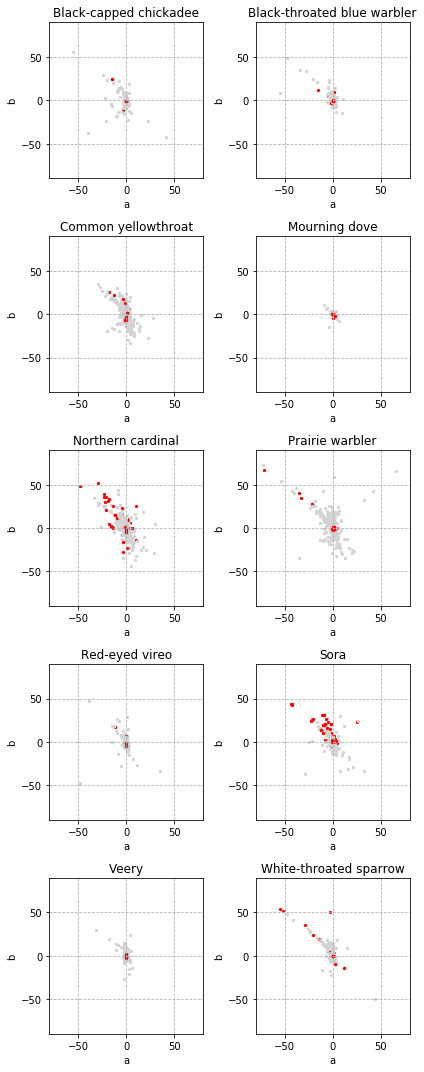

In [7]:
# plot a vs b
species_names = ['Black-capped chickadee',
                 'Black-throated blue warbler',
                 'Common yellowthroat',
                 'Mourning dove',
                 'Northern cardinal',
                 'Prairie warbler',
                 'Red-eyed vireo',
                 'Sora',
                 'Veery',
                 'White-throated sparrow']

n_stimuli = 10

colors_stim = ['red','green','blue','purple']
colors_imit = ['lightsalmon','lightgreen','skyblue','plum']
marker_size = 5

plt.figure(figsize=(6,15))

c = -1
for i_species in np.arange(n_species):
    plt.subplot(5,2,i_species+1)
    plt.ylabel('b')
    plt.xlabel('a')
    plt.xlim((-80,80))
    plt.ylim((-90,90))
    #plt.title(species_names[species_subset[i_species]-1])
    plt.title(species_names[i_species])
    plt.grid(linestyle='--')
    #plt.legend(title='light=imitations; dark=birdsong')
    
    for i_stimulus in np.arange(n_stimuli):
        c = c + 1
        
        for i_participant in np.arange(n_participants):
            a = a_imit_matrix[c, i_participant]
            b = b_imit_matrix[c, i_participant]
            plt.scatter(a, b, color='lightgrey',#colors_imit[i_species],
                       s=marker_size)
            
        a = a_stim_list[c]
        b = b_stim_list[c]
        plt.scatter(a, b, color='r',#colors_stim[i_species],
                   s=marker_size)
        
plt.tight_layout()

## Extras

In [8]:
# getting the states

need_stimuli = stimulus_matrix
need_data = imitation_matrix

states_sti_list = []
states_im_matrix = []

for i in np.arange(n_species * 10):   
    rdata_sti = need_stimuli[i]
    rdata_sti = rdata_sti[2:-1]
    start_sti, end_sti, pcen_sti = get_events_time(rdata_sti)
    a_sti, b_sti, max_list_sti, min_list_sti = get_coef(start_sti, end_sti, pcen_sti)
    states_sti = pitch_contour(a_sti, b_sti, max_list_sti, min_list_sti)
    states_sti_list.append(states_sti)
    
    states_im_list = []
    for j in np.arange(n_participants):
        rdata = need_data[j, i]
        rdata = rdata[2:-1]
        start, end, pcen = get_events_time(rdata)
        a, b, max_list, min_list = get_coef(start, end, pcen)
        states_im = pitch_contour(a, b, max_list, min_list)
        states_im_list.append(states_im)
    states_im_matrix.append(states_im_list)
        
states_sti_list = np.array(states_sti_list)
states_im_matrix = np.array(states_im_matrix).T



## Explanatory figures
This figure illustrates the process of segmenting audio using the PCEN-SNR curve

In [9]:
from matplotlib.lines import Line2D
import numpy.matlib
def visualize_segmentation(y, sr, label,
        n_mels=128, fmin=1000, fmax=11025, 
        hop_length=512, gain=0.8, bias=10, power=0.25, pcen_time_constant=0.06, eps=1e-06,
        medfilt_time_constant=0.05, normalized=True,
        peak_threshold=0.45, activity_threshold=0.2):
    
    # 1. Compute mel-frequency spectrogram
    melspec = librosa.feature.melspectrogram(
        y, sr=sr, fmin=fmin, fmax=fmax, hop_length=hop_length,
        n_mels=n_mels)
    
    # 2. Compute per-channel energy normalization (PCEN-SNR)
    pcen = librosa.core.pcen(melspec, sr=sr, gain=gain, bias=bias,
        power=power, hop_length=hop_length,
        time_constant=pcen_time_constant, eps=eps)
    
    # 3. compute PCEN-SNR detection function
    pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
    pcen_snr = librosa.power_to_db(pcen_snr / np.median(pcen_snr))
    if normalized:
        pcen_snr = pcen_snr / np.max(pcen_snr)
        
    pcen_snr_before_mdfilt = np.copy(pcen_snr)
        
    # 4. Apply median filtering.
    if medfilt_time_constant is not None:
        medfilt_hops = medfilt_time_constant * sr / hop_length
        kernel_size = max(1, 1 + 2 * round(medfilt_hops - 0.5))
        pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=kernel_size)
        
    if normalized:
        pcen_snr = pcen_snr / np.max(pcen_snr)
    
    # 5. Extract active segments.
    activity, start, end = threshold_activity(
        pcen_snr, peak_threshold, activity_threshold)
    
    # 6. Convert indices to seconds.
    start_times = np.round(np.array(start) * hop_length / sr, 3)
    end_times = np.round(np.array(end) * hop_length / sr, 3)

    # Compute mel-frequency spectrogram
    melspec = librosa.feature.melspectrogram(y, sr=sr)

    # Compute per-channel energy normalization (PCEN-SNR)
    pcen = librosa.core.pcen(melspec, sr=sr)

    
    begs = start_times
    ends = end_times

    plt.rcParams.update({'font.size': 15})
    axis_font_size = 16
    times = np.linspace(0, len(y)/sr, num=melspec.shape[1])
    plt.figure(figsize=(7.5, 5.5))
    
    # plot PCEN spectrogram
    #ax1 = plt.subplot(3, 1, 1)
    #librosa.display.specshow(pcen, sr=sr,fmin=fmin, fmax=fmax,
    #    x_axis='time', y_axis='mel', cmap='magma_r')
    #ax1.set_xlabel(None)
    #ax1.set_xticklabels([])
    #plt.title('Original audio: %s' %label)
    
    # plot PCEN spectrogram with blocked out areas where the snr was too low.
    begs0 = np.append(begs,times[-1])
    ends0 = np.append(np.arange(1), ends)
    pcen_blockedout = copy.deepcopy(pcen)
    for nseg in np.arange(ends0.size):
        loc_b = np.argmin(abs(times - begs0[nseg]))
        loc_e = np.argmin(abs(times - ends0[nseg]))
        #pcen_blockedout[:,loc_e:loc_b] = np.amin(pcen)
        pcen_blockedout[:,loc_e:loc_b] = pcen_blockedout[:,loc_e:loc_b]/1
    ax2 = plt.subplot(2,1,1)   
    librosa.display.specshow(pcen_blockedout, sr=sr,fmin=fmin, fmax=fmax,
            x_axis='time', y_axis='mel', cmap='magma_r')
    ax2.set_xlabel('Time (sec)', fontsize=axis_font_size)
    ax2.set_ylabel('Hz', fontsize=axis_font_size)
    
    for nseg in np.arange(begs.size):
        plt.axvline(x=begs[nseg], color="grey")
        plt.axvline(x=ends[nseg], color="black")
    
    #plt.annotate(s='A', xy=(0.05, 8000), fontsize=25, fontweight='bold', va='top')
                    
        
    ax2.tick_params(axis='x', labelsize=axis_font_size)
    ax2.tick_params(axis='y', labelsize=axis_font_size)
    plt.title('A) Segmented %s audio' %label)
    
    # plot median-filtered pcen-snr detection function along with the peak and activity thresholds
    peak_thresh_plt = np.matlib.repmat(peak_threshold,times.size,1)
    activity_thresh_plt = np.matlib.repmat(activity_threshold,times.size,1)
    ax3 = plt.subplot(2, 1, 2)
    plt.plot(times, pcen_snr_before_mdfilt, color="lightcoral", label='Original PCEN-SNR curve')
    plt.plot(times, pcen_snr, color="firebrick",
                label='Median-centered PCEN-SNR curve')
    plt.plot(times, peak_thresh_plt, color = "palegreen", label='Peak threshold')
    plt.plot(times, activity_thresh_plt, color = "green",
                label='Activity threshold')


    plt.xlim(times[0], times[-1])
    plt.ylim(0,1.1)
    plt.xlabel('Time (sec)', fontsize=axis_font_size)
    plt.ylabel('PCEN-SNR', fontsize=axis_font_size)
    plt.tight_layout()
    plt.title('B) PCEN-SNR curve and segmentation thresholds')
    ax3.set_xlabel(None)
    ax3.set_xticklabels([])
    ax3.set_yticks([0, 0.5, 1])
    ax3.tick_params(axis='y', labelsize=axis_font_size)
    #plt.annotate(s='B', xy=(0.05, 0.99), fontsize=25, fontweight='bold', va='top')


    
    custom_lines = [Line2D([0], [0], color="grey", lw=4),
                Line2D([0], [0], color="lightcoral", lw=4),
                Line2D([0], [0], color="palegreen", lw=4),
                Line2D([0], [0], color="black", lw=4),
                Line2D([0], [0], color="firebrick", lw=4),
                Line2D([0], [0], color="green", lw=4)]
    
    
    plt.legend(custom_lines, 
               ['Onsets of segments', 
                'Original SNR curve', 
                'Activity threshold',
                'Offsets of segments',
                'Median-centered curve',
                'Peak threshold'],
               bbox_to_anchor=(0., -1.1, 1., 1.02), loc=3, ncol=2,
               mode="expand", borderaxespad = 0.)
    
    plt.tight_layout()

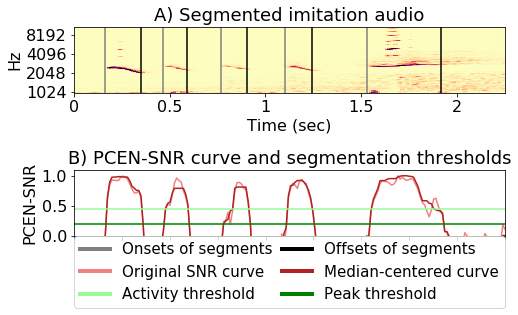

In [10]:
n_participant = 1-1
n_imitation = 11-1
sr = 44100


start_frames = round(0.65 * sr)
end_frames = round(2.9 * sr)

imit_audio = imitation_matrix[n_participant, n_imitation]
imit_audio = imit_audio[start_frames: end_frames]
ax1 = visualize_segmentation(y=imit_audio, sr=sr, label='imitation')
plt.savefig('../figures/vihar2019_segmentation_explained_imitation.png', dpi=750, bbox_inches="tight")






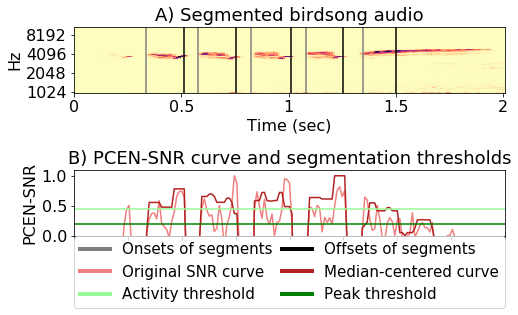

In [11]:
start_frames = round(0.25 * sr)
end_frames = len(imit_audio + start_frames)

stim_audio = stimulus_matrix[n_imitation, ]
stim_audio = stim_audio[start_frames: end_frames]
ax2 = visualize_segmentation(y=stim_audio, sr=sr, label='birdsong')
plt.savefig('../figures/vihar2019_segmentation_explained_stimulus.png', dpi=750, bbox_inches="tight")
